In [1]:
import findspark

findspark.init()

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IDF, HashingTF, StopWordsRemover

from utils import normalizeContentDf, tokenizeDf

In [2]:
# Create Spark Session
spark = SparkSession.builder.appName('comment_nlp').config("spark.driver.memory", "6g").getOrCreate()

21/10/05 00:13:07 WARN Utils: Your hostname, zmediatech-huytq11 resolves to a loopback address: 127.0.0.1; using 192.168.1.17 instead (on interface wlp3s0)
21/10/05 00:13:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/05 00:13:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Read raw data
rawData = spark.read.csv('./input/train.csv', inferSchema=True, header=True)
rawValidData = spark.read.csv('./input/validation.csv', inferSchema=True, header=True)
rawTestData = spark.read.csv('./input/test.csv', inferSchema=True, header=True)

# Split raw data
rawData.repartition(20).write.partitionBy("status").csv('./splitted/train', mode="overwrite")
rawValidData.repartition(20).write.partitionBy("status").csv('./splitted/valid', mode="overwrite")
rawTestData.repartition(20).write.partitionBy("status").csv('./splitted/test', mode="overwrite")

# Read splitted data
schemaDdl = "content STRING, status INTEGER"
sparkReader = spark.read.schema(schemaDdl)
trainingData = sparkReader.csv('./splitted/train')
validationData = sparkReader.csv('./splitted/valid')
testData = sparkReader.csv('./splitted/test')

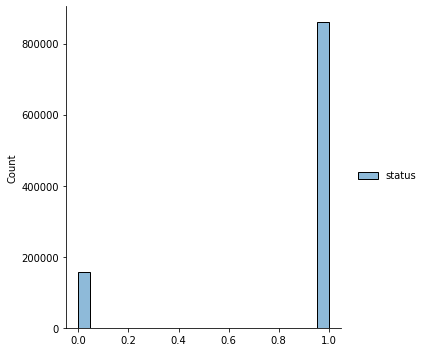

In [5]:
import pandas as pd
import seaborn as sns

df = pd.concat([rawData.toPandas(), rawValidData.toPandas(), rawTestData.toPandas()], axis=0)

sns.displot(df)

In [4]:
# Normalize content
trainingData = normalizeContentDf(trainingData).filter("content != ''").select("content", "status").coalesce(3)
validationData = normalizeContentDf(validationData).filter("content != ''").select("content", "status").coalesce(3)
testData = normalizeContentDf(testData).filter("content != ''").select("content", "status").coalesce(3)

trainingData.toPandas().select("content", "status").to_csv('./input/train_filtered.csv')
validationData.toPandas().select("content", "status").to_csv('./input/validation_filtered.csv')
testData.toPandas().select("content", "status").to_csv('./input/test_filtered.csv')

In [5]:
# Tokenize Vietnamese before process
trainingData = tokenizeDf(trainingData)
validationData = tokenizeDf(validationData)
testData = tokenizeDf(testData)

In [6]:
# Read Vietnamese Stopwords
stopwords_file = open("./vietnamese-stopwords.txt", "r")
stopwords_list = stopwords_file.read().split('\n')

# Define pipeline
stopwords_remover = StopWordsRemover(
    inputCol="content1",
    outputCol="content2",
    stopWords=stopwords_list,
)
hashing_tf = HashingTF(
    inputCol="content2",
    outputCol="term_frequency",
)
idf = IDF(
    inputCol="term_frequency",
    outputCol="features",
    minDocFreq=5
)
lr = LogisticRegression(labelCol="status")
sematic_analysis_pipeline = Pipeline(
    stages=[stopwords_remover, hashing_tf, idf, lr]
)

In [7]:
# Create model
model = sematic_analysis_pipeline.fit(trainingData)

21/10/03 10:46:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:48:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:49:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/03 10:49:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/03 10:51:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:51:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:51:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:51:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:51:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:51:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:51:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/03 10:51:

In [8]:
# Evaluate model
trained_df = model.transform(trainingData)
val_df = model.transform(validationData)
test_df = model.transform(testData)

trained_df.show()
val_df.show()
test_df.show()

evaluator = MulticlassClassificationEvaluator(labelCol="status", metricName="accuracy")
accuracy_val = evaluator.evaluate(val_df)
accuracy_test = evaluator.evaluate(test_df)

print(f"Validation accuracy: {accuracy_val*100:.5f}%")
print(f"Test accuracy: {accuracy_test*100:.5f}%")

21/10/03 10:52:06 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|             content|status|            content1|            content2|      term_frequency|            features|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| Nam Mô A Di Đà Phật|     1|[nam_mô, a_di_đà_...|[nam_mô, a_di_đà_...|(262144,[8054,134...|(262144,[8054,134...|[-2.7926204852071...|[0.05772425610561...|       1.0|
|giữ vững top nào ...|     1|[giữ, vững, top, ...|    [vững, top, đóm]|(262144,[18176,12...|(262144,[18176,12...|[-3.3855588792022...|[0.03274984643754...|       1.0|
|Greetings from Ge...|     1|[greetings, from,...|[greetings, from,...|(262144,[44462,63...|(262144,[44462,63...|[-2.3368209573046...|[0.08811902957766...|       1.0

21/10/03 10:52:08 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|             content|status|            content1|            content2|      term_frequency|            features|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Xuất sắc luôn anh ưi|     1|[xuất_sắc, luôn, ...|      [xuất_sắc, ưi]|(262144,[167020,1...|(262144,[167020,1...|[-3.2479173176371...|[0.03740179775665...|       1.0|
|             hay quá|     1|          [hay, quá]|                  []|      (262144,[],[])|      (262144,[],[])|[-1.6662584397762...|[0.15892366371991...|       1.0|
|   hay quá đi anh ơi|     1|[hay, quá, đi, an...|                [đi]|(262144,[95276],[...|(262144,[95276],[...|[-2.1966578547489...|[0.10005101659639...|       1.0

21/10/03 10:52:12 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|             content|status|            content1|            content2|      term_frequency|            features|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| Nam Mô A Di Đà Phật|     1|[nam_mô, a_di_đà_...|[nam_mô, a_di_đà_...|(262144,[8054,134...|(262144,[8054,134...|[-2.7926204852071...|[0.05772425610561...|       1.0|
|       Cmt gì thế bà|     1|  [cmt, gì, thế, bà]|               [cmt]|(262144,[244099],...|(262144,[244099],...|[-1.7383795481873...|[0.14951887900978...|       1.0|
|      hay lắm ok đấy|     1| [hay, lắm, ok, đấy]|      [lắm, ok, đấy]|(262144,[39795,19...|(262144,[39795,19...|[-3.2380505499560...|[0.03775865596950...|       1.0

21/10/03 10:52:15 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
21/10/03 10:52:33 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Validation accuracy: 87.31911%
Test accuracy: 87.18459%


In [9]:
# Save model
model.write().overwrite().save('./model_lr/')

21/10/03 10:52:48 WARN TaskSetManager: Stage 131 contains a task of very large size (4184 KiB). The maximum recommended task size is 1000 KiB.
